# [0] Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import torch
from tqdm.auto import tqdm
from colorama import Fore, Style
import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

device = "cuda" if torch.cuda.is_available() else 'cpu'

# [1] Loading [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) Dataset

Only need to run once

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz # downloading
!tar xzf aclImdb_v1.tar.gz  # extracting

--2024-10-28 23:32:25--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  10.8MB/s    in 17s     

2024-10-28 23:32:52 (4.72 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



Creating Pandas dataframe

In [ ]:
def fetch_reviews(path):
  data = []
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())

  return data

In [ ]:
df_train_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/test/neg/'), 'label': 0})

df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
df

,review,label
0,I will never forget this film or the events th...,1
1,There is no director I like more than Mamoru O...,1
2,This is just a short comment but I stumbled on...,1
3,I've often wondered just how much CASPER was m...,1
4,"After seeing Jeremy Brett as Sherlock Holmes, ...",1
...,...,...
49995,Saw this last night and being a fan of the fir...,0
49996,Your time and brains will be much better spent...,0
49997,"""Speck"" was apparently intended to be a biopic...",0
49998,"As usual, leader Leo Gorcey (as Slip Mahoney) ...",0


In [ ]:
df['review'].isnull().sum()

np.int64(0)

In [ ]:
print("Total Number of positive reviews in data: ", df[df['label']==1].shape[0])
print("Total Number of negative reviews in data: ", df[df['label']==0].shape[0])

Total Number of positive reviews in data:  25000
Total Number of negative reviews in data:  25000


# [2] Cleaning Movie Reviews Text

In [ ]:
%%capture
import re
import nltk
nltk.download('punkt_tab') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!unzip -o /usr/share/nltk_data/corpora/punkt_tab.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):

  # data cleaning
  review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
  review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words

  # lowercase
  review = review.lower()

  # tokenization
  tokens = nltk.word_tokenize(review) # converts review to tokens

  # stop_words removal
  review = [word for word in tokens if word not in stop_words] #removing stop words

  # lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]

  # join words in preprocessed review
  review = ' '.join(review)

  return review

In [ ]:
df['preprocessed_review'] = df['review'].apply(lambda review: data_preprocessing(review))
df

,review,label,preprocessed_review
0,I will never forget this film or the events th...,1,never forget film event lead jonestown guyana ...
1,There is no director I like more than Mamoru O...,1,director like mamoru oshii sadly even though d...
2,This is just a short comment but I stumbled on...,1,short comment stumbled onto movie chance loved...
3,I've often wondered just how much CASPER was m...,1,often wondered much casper meant child issue r...
4,"After seeing Jeremy Brett as Sherlock Holmes, ...",1,seeing jeremy brett sherlock holmes actor ever...
...,...,...,...
49995,Saw this last night and being a fan of the fir...,0,saw last night fan first demon hoped sequel wo...
49996,Your time and brains will be much better spent...,0,time brain much better spent reading listening...
49997,"""Speck"" was apparently intended to be a biopic...",0,speck apparently intended biopic related seria...
49998,"As usual, leader Leo Gorcey (as Slip Mahoney) ...",0,usual leader leo gorcey slip mahoney bowery bo...


If time is taken by the above code, the processed DataFrame can be saved

In [ ]:
df.to_parquet('df_preprocessed_review.parquet')
df = pd.read_parquet('df_preprocessed_review.parquet')
df

,review,label,preprocessed_review
0,I will never forget this film or the events th...,1,never forget film event lead jonestown guyana ...
1,There is no director I like more than Mamoru O...,1,director like mamoru oshii sadly even though d...
2,This is just a short comment but I stumbled on...,1,short comment stumbled onto movie chance loved...
3,I've often wondered just how much CASPER was m...,1,often wondered much casper meant child issue r...
4,"After seeing Jeremy Brett as Sherlock Holmes, ...",1,seeing jeremy brett sherlock holmes actor ever...
...,...,...,...
49995,Saw this last night and being a fan of the fir...,0,saw last night fan first demon hoped sequel wo...
49996,Your time and brains will be much better spent...,0,time brain much better spent reading listening...
49997,"""Speck"" was apparently intended to be a biopic...",0,speck apparently intended biopic related seria...
49998,"As usual, leader Leo Gorcey (as Slip Mahoney) ...",0,usual leader leo gorcey slip mahoney bowery bo...


# [3] Splitting into Train and Validation sets

In [ ]:
from sklearn.model_selection import train_test_split

data = df.drop(['label'], axis=1, inplace=False)
targets = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, stratify=targets)

print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (35000, 2) (35000,)
Test data: (15000, 2) (15000,)


In [ ]:
X_train

,review,preprocessed_review
12065,Most people (36) gave this movie a 10 and thos...,people 36 gave movie 10 critical maybe expecte...
29080,Well every scene so perfectly presented. Never...,well every scene perfectly presented never see...
16895,Tromaville High has become an amoral wasteland...,tromaville high become amoral wasteland filth ...
40313,***SPOILERS*** This movie - called EATEN ALIVE...,spoiler movie called eaten alive uk quite poss...
16527,"Possibly not, but it is awful. Even the fantas...",possibly not awful even fantastic cast cant sa...
...,...,...
18102,"This is, without doubt, one of the worst films...",without doubt one worst film ever seen plot fu...
46181,Saw this movie last night. I don't usually com...,saw movie last night usually comment good bad ...
18347,Now i have never ever seen a bad movie in all ...,never ever seen bad movie year song movie phys...
34361,I really enjoyed this movie. Yes there was dis...,really enjoyed movie yes disrespect throughout...


# [4] Vectorizer Movie Reviews

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

max_features = 5000 # or None

vectorizer = TfidfVectorizer(max_features=max_features).fit(X_train.preprocessed_review)
vectorizer

CPU times: user 1.42 s, sys: 15.6 ms, total: 1.44 s
Wall time: 1.43 s


TfidfVectorizer(max_features=5000)

Saving vectorizer for inference

In [ ]:
os.makedirs('checkpoints', exist_ok=True)
joblib.dump(vectorizer, "checkpoints/vectorizer.joblib")

['checkpoints/vectorizer.joblib']

In [ ]:
print("Vocabulary size:", len(vectorizer.vocabulary_))

Vocabulary size: 5000


In [ ]:
vectorizer.vocabulary_

{'people': np.int64(3247),
 'gave': np.int64(1907),
 'movie': np.int64(2945),
 '10': np.int64(2),
 'critical': np.int64(1100),
 'maybe': np.int64(2798),
 'expected': np.int64(1615),
 'something': np.int64(4118),
 'else': np.int64(1480),
 'one': np.int64(3133),
 'favorite': np.int64(1704),
 '80': np.int64(72),
 'grows': np.int64(2019),
 'got': np.int64(1973),
 'dvd': np.int64(1417),
 '20': np.int64(50),
 'year': np.int64(4984),
 'later': np.int64(2554),
 'still': np.int64(4240),
 'not': np.int64(3070),
 'disappoint': np.int64(1315),
 'plenty': np.int64(3331),
 'action': np.int64(117),
 'drama': np.int64(1375),
 'romance': np.int64(3778),
 'even': np.int64(1570),
 'comedy': np.int64(908),
 'add': np.int64(128),
 'great': np.int64(1993),
 'car': np.int64(688),
 'chase': np.int64(773),
 'weapon': np.int64(4857),
 'lot': np.int64(2686),
 'stuff': np.int64(4291),
 'blowing': np.int64(528),
 'fun': np.int64(1879),
 'edge': np.int64(1447),
 'seat': np.int64(3896),
 'experience': np.int64(1618)

In [ ]:
X_train_vec = vectorizer.transform(X_train.preprocessed_review)
X_test_vec = vectorizer.transform(X_test.preprocessed_review)

print('X_train_vec shape: ', X_train_vec.shape)
print('X_test_vec shape: ', X_test_vec.shape)

X_train_vec shape:  (35000, 5000)
X_test_vec shape:  (15000, 5000)


# [5] Creating Tensor Dataset and Dataloader

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=16)

X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()
INPUT_SIZE = len(vectorizer.vocabulary_)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              pin_memory=True,
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              drop_last=True,
                              shuffle=True)

val_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE*2,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             persistent_workers=True,
                             drop_last=False,
                             shuffle=False)

In [ ]:
inputs, targets = next(iter(train_dataloader))
inputs.shape, targets.shape

(torch.Size([128, 5000]), torch.Size([128]))

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# [6] *Recurrent Neural Network* (RNN)

In [ ]:
from torch import nn

class ImdbRNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.rnn_hidden_size = 130
        self.rnn_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # RNN Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, rnn_hidden_size], [rnn_layers, rnn_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.rnn = nn.RNN(input_size=self.input_size,
                          hidden_size=self.rnn_hidden_size,
                          num_layers=self.rnn_layers,
                          bias=True,
                          batch_first=True,
                          dropout=0.4,
                          bidirectional=False
                         )


        # Classifier Head
        # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, rnn_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.rnn_hidden_size),

            # [BATCH_SIZE, rnn_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.rnn_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.rnn_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        rnn_op, _ = self.rnn(x)
        return self.layer_stack(rnn_op)
        # return self.fc(rnn_op)

In [ ]:
# inputs, targets = inputs.to(device), targets.to(device)
# logits = ImdbRNN().to(device)(inputs)

# [7] Training *RNN*

In [ ]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbRNN().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.7006, 0.6962) | Acc: (51.0474, 50.4955)% | F1: (54.5033, 54.3080)% |
Epoch:  2 | Loss: (0.6942, 0.6918) | Acc: (51.0731, 51.7235)% | F1: (56.9294, 63.9045)% |
Epoch:  3 | Loss: (0.6921, 0.6902) | Acc: (51.6197, 51.2715)% | F1: (56.5330, 65.2321)% |
Epoch:  4 | Loss: (0.6902, 0.6841) | Acc: (52.6872, 57.2752)% | F1: (59.8641, 66.4397)% |
Epoch:  5 | Loss: (0.6272, 0.5559) | Acc: (64.1369, 70.0181)% | F1: (67.7389, 71.3772)% |
Epoch:  6 | Loss: (0.4093, 0.3499) | Acc: (83.1988, 84.6036)% | F1: (83.4597, 84.9614)% |
Epoch:  7 | Loss: (0.3493, 0.2777) | Acc: (86.4097, 88.7959)% | F1: (86.5734, 88.7196)% |
Epoch:  8 | Loss: (0.3025, 0.2943) | Acc: (88.8937, 87.7958)% | F1: (89.0086, 88.0344)% |
Epoch:  9 | Loss: (0.2933, 0.3095) | Acc: (89.3830, 87.4983)% | F1: (89.4195, 87.7879)% |
Epoch:  10 | Loss: (0.2728, 0.3091) | Acc: (90.1643, 87.9067)% | F1: (90.1615, 87.9383)% |
Model checkpoint saved at epoch 7


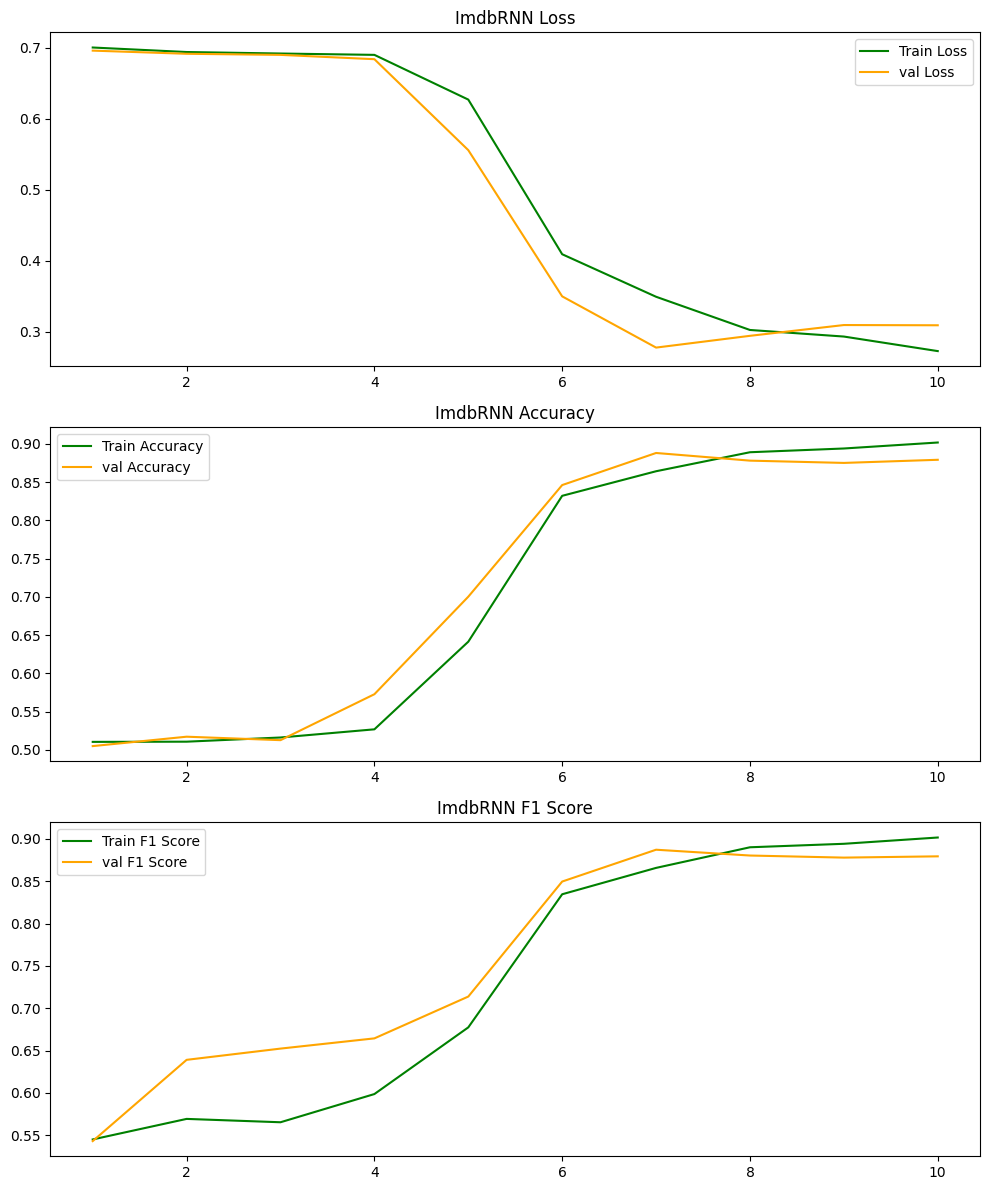

In [ ]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbRNN"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////

# [8] *Long Short-Term Memory* (LSTM) Recurrent Neural Network

In [ ]:
from torch import nn

class ImdbLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.lstm_hidden_size = 130
        self.lstm_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # LSTM Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, lstm_hidden_size], [lstm_layers, lstm_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.lstm = nn.LSTM(input_size=self.input_size,
                           hidden_size=self.lstm_hidden_size,
                           num_layers=self.lstm_layers,
                           bias=True,
                           batch_first=True,
                           dropout=0.4,
                           bidirectional=False
                          )



        # Classifier Head
        # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, lstm_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.lstm_hidden_size),

            # [BATCH_SIZE, lstm_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.lstm_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.lstm_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        lstm_op, _ = self.lstm(x)
        return self.layer_stack(lstm_op)
        # return self.fc(lstm_op)

# [9] Training *LSTM*

In [ ]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbLSTM().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.7030, 0.6935) | Acc: (50.3033, 54.5554)% | F1: (43.8404, 44.9819)% |
Epoch:  2 | Loss: (0.6946, 0.6936) | Acc: (50.4894, 49.8369)% | F1: (50.8674, 65.9409)% |
Epoch:  3 | Loss: (0.6935, 0.6904) | Acc: (50.6925, 57.1689)% | F1: (54.1595, 62.5869)% |
Epoch:  4 | Loss: (0.4801, 0.2960) | Acc: (78.2309, 87.6021)% | F1: (77.6366, 88.0439)% |
Epoch:  5 | Loss: (0.2907, 0.2814) | Acc: (89.2571, 88.3771)% | F1: (89.3200, 88.5477)% |
Epoch:  6 | Loss: (0.2573, 0.2927) | Acc: (90.6937, 87.8136)% | F1: (90.7214, 87.9139)% |
Epoch:  7 | Loss: (0.2373, 0.2992) | Acc: (91.5035, 88.0851)% | F1: (91.5263, 88.2961)% |
Epoch:  8 | Loss: (0.2253, 0.3086) | Acc: (92.0702, 87.7342)% | F1: (92.0868, 87.5226)% |
Epoch:  9 | Loss: (0.2186, 0.3028) | Acc: (92.3678, 87.5794)% | F1: (92.3778, 87.6234)% |
Epoch:  10 | Loss: (0.2076, 0.3264) | Acc: (92.9859, 87.5596)% | F1: (92.9925, 87.6333)% |
Model checkpoint saved at epoch 5


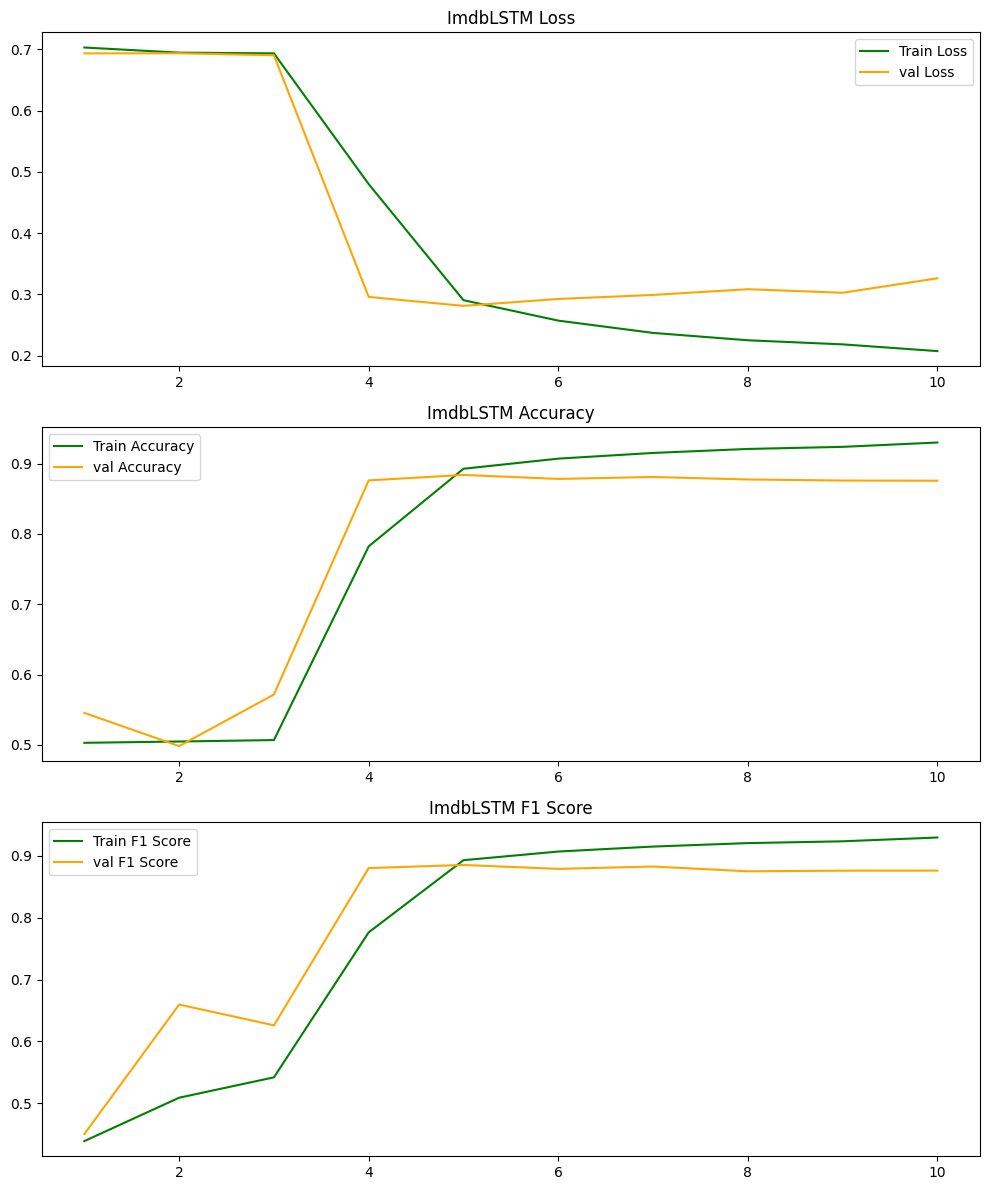

In [ ]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbLSTM"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

/////////////////////////////////////////////////////////////////////////////////////////////////////////

# [10] *Gated Recurrent Unit* (GRU) Recurrent Neural Network

In [ ]:
from torch import nn

class ImdbGRU(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_size = INPUT_SIZE
        self.gru_hidden_size = 130
        self.gru_layers = 3
        self.fc_size = [64, 32, 16]
        self.op_size = 1


        # GRU Layer
        # [BATCH_SIZE, max_features] --> ([BATCH_SIZE, gru_hidden_size], [gru_layers, gru_hidden_size])
        # [128, 5000] --> ([128, 130], (1, 130))
        self.gru = nn.GRU(input_size=self.input_size,
                           hidden_size=self.gru_hidden_size,
                           num_layers=self.gru_layers,
                           bias=True,
                           batch_first=True,
                           dropout=0.4,
                           bidirectional=False
                          )



        # Classifier Head
        # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, op_size]
        # [128, 130] --> [129, 1]
        self.layer_stack = nn.Sequential(

            # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, gru_hidden_size]
            # [128, 130] --> [128, 130]
            nn.LayerNorm(normalized_shape=self.gru_hidden_size),

            # [BATCH_SIZE, gru_hidden_size] --> [BATCH_SIZE, fc_size[0]]
            # [128, 130] --> [128, 64]
            nn.Linear(in_features=self.gru_hidden_size, out_features=self.fc_size[0], bias=True),
            nn.BatchNorm1d(self.fc_size[0]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[0]] --> [BATCH_SIZE, fc_size[1]]
            # [128, 64] --> [128, 32]
            nn.Linear(in_features=self.fc_size[0], out_features=self.fc_size[1], bias=True),
            nn.BatchNorm1d(self.fc_size[1]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[1]] --> [BATCH_SIZE, fc_size[2]]
            # [128, 32] --> [128, 16]
            nn.Linear(in_features=self.fc_size[1], out_features=self.fc_size[2], bias=True),
            nn.BatchNorm1d(self.fc_size[2]),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # [BATCH_SIZE, fc_size[2]] --> [BATCH_SIZE, op_size]
            # [128, 16] --> [128, 1]
            nn.Linear(in_features=self.fc_size[2], out_features=self.op_size, bias=True)
        )

        self.fc = nn.Linear(in_features=self.gru_hidden_size, out_features=self.op_size, bias=True)


    def forward(self, x):
        gru_op, _ = self.gru(x)
        return self.layer_stack(gru_op)
        # return self.fc(gru_op)

# [11] Training *GRU*

In [ ]:
epochs = 10
loss_function = torch.nn.BCEWithLogitsLoss().to(device)
model = ImdbGRU().to(device)
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.001)

Epoch:  1 | Loss: (0.7019, 0.6928) | Acc: (49.9742, 50.1352)% | F1: (44.8843, 8.1551)% |
Epoch:  2 | Loss: (0.6857, 0.5309) | Acc: (53.5943, 83.7147)% | F1: (49.5904, 82.5009)% |
Epoch:  3 | Loss: (0.3885, 0.2880) | Acc: (86.0377, 88.1868)% | F1: (85.9663, 88.3632)% |
Epoch:  4 | Loss: (0.2825, 0.2803) | Acc: (89.9182, 88.3279)% | F1: (89.8974, 88.5060)% |
Epoch:  5 | Loss: (0.2563, 0.2932) | Acc: (90.9112, 88.0077)% | F1: (90.8816, 87.8796)% |
Epoch:  6 | Loss: (0.2413, 0.2955) | Acc: (91.4807, 87.8997)% | F1: (91.4428, 88.0299)% |
Epoch:  7 | Loss: (0.2344, 0.2962) | Acc: (91.6667, 87.9415)% | F1: (91.6455, 88.1429)% |
Epoch:  8 | Loss: (0.2279, 0.3041) | Acc: (92.0759, 87.4359)% | F1: (92.0693, 87.7814)% |
Epoch:  9 | Loss: (0.2199, 0.3062) | Acc: (92.3134, 87.6038)% | F1: (92.2804, 87.5423)% |
Epoch:  10 | Loss: (0.2134, 0.3220) | Acc: (92.5481, 87.4031)% | F1: (92.5196, 87.6244)% |
Model checkpoint saved at epoch 4


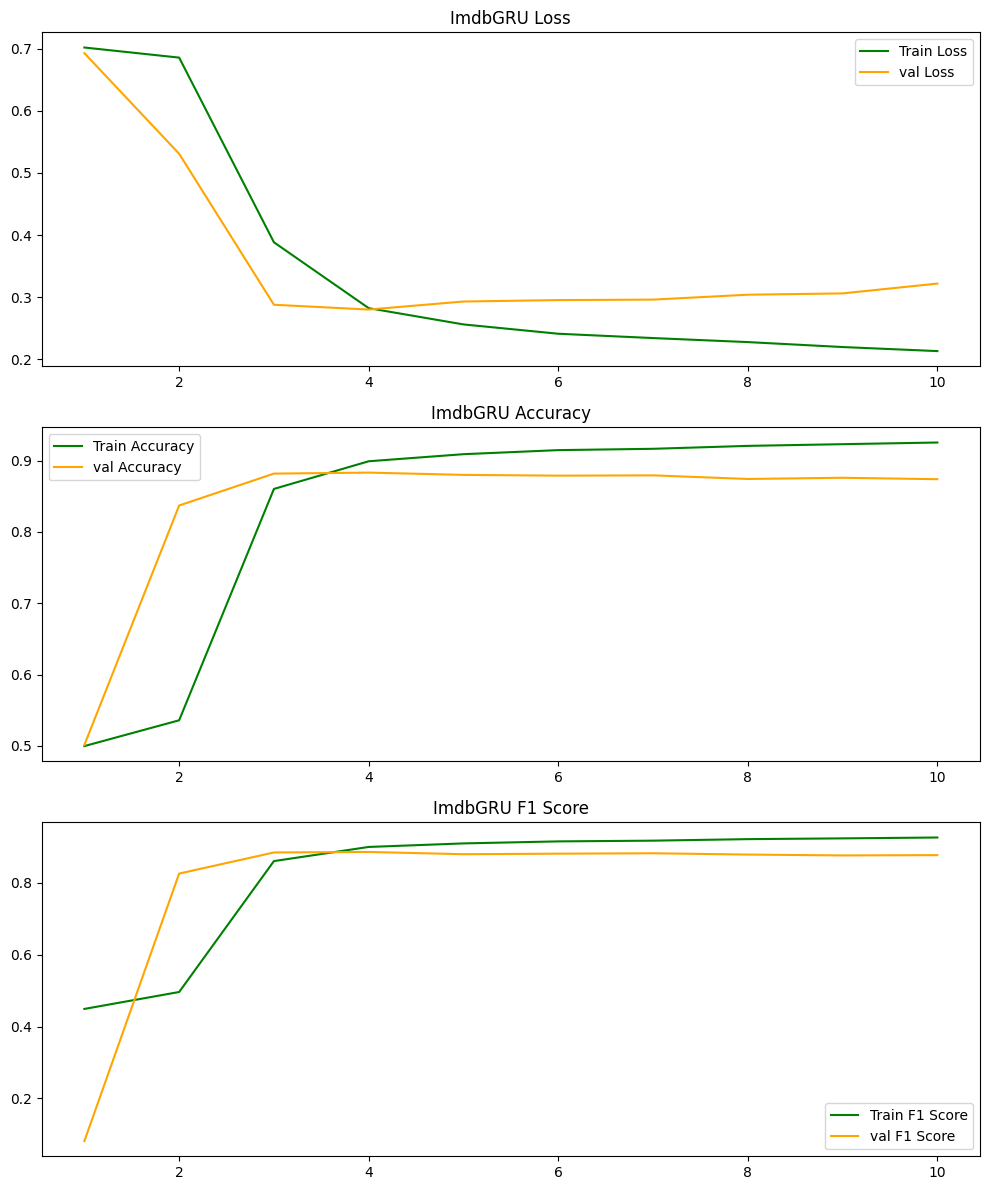

In [ ]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


MODEL_NAME = "ImdbGRU"
best_cum_val_acc = 0
best_weights = None
best_epoch = np.inf

results = {"train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": [],
            "train_f1": [],
            "val_f1": []
            }


for epoch in range(epochs):
    cum_train_loss, cum_train_acc, cum_train_f1 = 0, 0, 0
    model.train()

    for batch, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        y_logits = model(inputs).squeeze()

        train_loss = loss_function(y_logits, targets)

        optimizer.zero_grad()
        train_loss.backward()
        cum_train_loss += train_loss.item()
        optimizer.step()


        y_probs = y_logits.sigmoid()
        y_preds = (y_probs >= 0.5).float()

        cum_train_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
        cum_train_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

    cum_train_loss /= len(train_dataloader)
    cum_train_acc /= len(train_dataloader)
    cum_train_f1 /= len(train_dataloader)

    # validation loop
    cum_val_loss, cum_val_acc, cum_val_f1 = 0, 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            y_logits = model(inputs).squeeze()

            test_loss = loss_function(y_logits, targets)
            cum_val_loss += test_loss.item()

            y_probs = y_logits.sigmoid()
            y_preds = (y_probs >= 0.5).float()

            cum_val_acc += accuracy_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())
            cum_val_f1 += f1_score(targets.detach().cpu().numpy(), y_preds.detach().cpu().numpy())

        cum_val_loss /= len(val_dataloader)
        cum_val_acc /= len(val_dataloader)
        cum_val_f1 /= len(val_dataloader)


    if cum_val_acc > best_cum_val_acc:
        best_cum_val_acc = cum_val_acc
        best_weights = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    epoch_display = f" {epoch+1}" if epoch < 10 else epoch
    print(f"Epoch: {Fore.YELLOW}{epoch_display}{Style.RESET_ALL} | "
            f"Loss: ({Fore.YELLOW}{cum_train_loss:.4f}, {cum_val_loss:.4f}{Style.RESET_ALL}) | "
            f"Acc: ({Fore.YELLOW}{100*cum_train_acc:.4f}, {100*cum_val_acc:.4f}{Style.RESET_ALL})% | "
            f"F1: ({Fore.YELLOW}{100*cum_train_f1:.4f}, {100*cum_val_f1:.4f}{Style.RESET_ALL})% |")


    results["train_loss"].append(cum_train_loss)
    results["val_loss"].append(cum_val_loss)
    results["train_acc"].append(cum_train_acc)
    results["val_acc"].append(cum_val_acc)
    results["train_f1"].append(cum_train_f1)
    results["val_f1"].append(cum_val_f1)


### Saving Best Model weights
os.makedirs('checkpoints', exist_ok=True)
torch.save(best_weights, f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar")
print(f'Model checkpoint saved at epoch {best_epoch}')

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='green')
plt.plot(np.arange(1,epochs+1), results["val_loss"], label='val Loss', color='orange')
plt.title(f'{MODEL_NAME} Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.arange(1,epochs+1), results["train_acc"], label='Train Accuracy', color='green')
plt.plot(np.arange(1,epochs+1), results["val_acc"], label='val Accuracy', color='orange')
plt.title(f'{MODEL_NAME} Accuracy')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='green')
plt.plot(np.arange(1,epochs+1), results["val_f1"], label='val F1 Score', color='orange')
plt.title(f'{MODEL_NAME} F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

///////////////////////////////////////////////////////////////////////////////////////////////////////

# [12] Predicting Sentiment of Random Movie Review

In [ ]:
MODEL_NAME = "ImdbGRU"
model = ImdbGRU().to(device)
model.load_state_dict(torch.load(f"checkpoints/{MODEL_NAME}_checkpoint.pth.tar", weights_only=True))

<All keys matched successfully>

In [ ]:
vectorizer = joblib.load("checkpoints/vectorizer.joblib")
vectorizer

TfidfVectorizer(max_features=5000)

In [ ]:
def predict_sentiment(model, vectorizer, sentence):

    inputs = [data_preprocessing(sentence)]
    inputs = vectorizer.transform(inputs)
    inputs = torch.tensor(inputs.toarray(), dtype=torch.float32).to(device)

    model.eval()
    with torch.inference_mode():
        inputs_logits = model(inputs).squeeze()
        inputs_probs = inputs_logits.sigmoid()
        inputs_preds = (inputs_probs >= 0.5).float()

    if inputs_preds == 1.0:
        sentiment = "Positive"
    else:
        sentiment = "Negitive"

    return sentiment

In [ ]:
sentences = [
    "This movie is really good",
    "You should watch this movie only if you nothing else to do.",
    "I've had mosquito bites that were more passionate than this undead, unrequited, and altogether unfun pseudo-romantic riff on Romeo and Juliet",
    "An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. ",
    "Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movie titles like brahmastra .. and doing ending like bahubali lacks originality .. Vfx were good ..Bolloywood needs some originality , brains and better script writing and mature content .. Brahmastra is just one time watch .. only if you have time and longing for a time pass movie..",
    "I never thought that this movie would be good, but it turned out to be great",
    "While I had the misfortune to see 'Bright' in a theater, most people will simply press 'play' out of curiosity on their TV remote. I am willing to concede that this might elevate the experience a little ... the ability to take a quick trip to the kitchen or restroom after shouting 'no, don't pause it' to your partner on the couch will be liberating."
    ]

for sentence in sentences:
    print(sentence)
    print(predict_sentiment(model, tokenizer, sentence))
    print()

This movie is really good
Positive

You should watch this movie only if you nothing else to do.
Negitive

I've had mosquito bites that were more passionate than this undead, unrequited, and altogether unfun pseudo-romantic riff on Romeo and Juliet
Negitive

An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. 
Positive

Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movi